# Understanding NuScenes dataset and creating functions
Import packages

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

Load nuscnenes mini dataset

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.356 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


Look at what each scene contains based on description etc. Below, the city/area is significant to us as well as the roadway type/description.

In [3]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

Below, we can see how many samples we have of each type of scenario/scene. This gives us a greater insight into what the dataset contains. The cell underneath then allows us to see the different information we can find within the dataset and allows us to explore NuScenes a bit more.

In [4]:
# Sample type and number of that sample
for i in range(len(nusc.scene)):
    my_scene = nusc.scene[i]
    description = my_scene['description']
    nbr_samples = my_scene['nbr_samples']
    print(description, ":", nbr_samples, "samples")

Parked truck, construction, intersection, turn left, following a van : 39 samples
Many peds right, wait for turning car, long bike rack left, cyclist : 40 samples
Wait at intersection, bicycle, large truck, peds crossing crosswalk, ped with stroller : 41 samples
Parking lot, parked cars, jaywalker, bendy bus, gardening vehicles : 41 samples
Arrive at busy intersection, bus, wait at intersection, bicycle, peds : 41 samples
Scooter, peds on sidewalk, bus, cars, truck, fake construction worker, bicycle, cross intersection, car overtaking us : 40 samples
Parking lot, bicycle rack, parked bicycles, bus, many peds, parked scooters, parked motorcycle : 41 samples
Night, big street, bus stop, high speed, construction vehicle : 41 samples
Night, after rain, many peds, PMD, ped with bag, jaywalker, truck, scooter : 40 samples
Night, peds in sidewalk, peds cross crosswalk, scooter, PMD, difficult lighting : 40 samples


In [5]:
# A sample example with its data
first_sample_token = my_scene['first_sample_token']
# The rendering command below is commented out because it tends to crash in notebooks
# nusc.render_sample(first_sample_token)
my_sample = nusc.get('sample', first_sample_token)

Here, we look at different timestamps and see how the annotations around the car changes. This is important as external factors create a huge difference in safe driving. Not sure yet if this is relevent to the study.

In [6]:
def timestamp_change(my_instance):

    first_token = my_instance['first_annotation_token']
    last_token = my_instance['last_annotation_token']
    nbr_samples = my_instance['nbr_annotations']
    current_token = first_token

    i = 0
    found_change = False
    while current_token != last_token:
        current_ann = nusc.get('sample_annotation', current_token)
        current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])['name']

        if i == 0:
            pass
        elif current_attr != last_attr:
            print("Changed from `{}` to `{}` at timestamp {} out of {} annotated timestamps".format(last_attr, current_attr, i, nbr_samples))
            found_change = True

        next_token = current_ann['next']
        current_token = next_token
        last_attr = current_attr
        i += 1
        
my_instance = nusc.instance[27]
timestamp_change(my_instance)

Changed from `pedestrian.moving` to `pedestrian.standing` at timestamp 21 out of 39 annotated timestamps


Here we can calculate the visibility in the scene which is important when it comes to crashes and we can relate it to the factors we found from the crash data.

In [7]:
my_instance = nusc.instance[27]

def visibility(my_instance):
    first_token = my_instance['first_annotation_token']
    last_token = my_instance['last_annotation_token']
    nbr_samples = my_instance['nbr_annotations']
    current_token = first_token

    i = 0
    while current_token != last_token:

        visibility_token = nusc.get('sample_annotation', current_token)['visibility_token']
        current_ann = nusc.get('sample_annotation', current_token)

        print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
        # nusc.render_annotation(current_token)

        next_token = current_ann['next']
        current_token = next_token
        i += 1
        
# my_instance = nusc.instance[27]
# visibility(my_instance)

Not sure if I need this:

In [8]:
# get calibrated sensor translation
def cal_sensor_translation(cal_sens):
    cal_sensor_token = nusc.get('calibrated_sensor', cal_sens)
    cal_sensor_translation = cal_sensor_token['translation']
    cal_sensor_translation = np.array(cal_sensor_translation)
    return cal_sensor_translation

# get ego pose sensor translation
def ego_pose_translation(ego_sens):
    ego_pose = nusc.get('ego_pose', ego_sens)
    ego_pose_translation = ego_pose['translation']
    ego_pose_translation = np.array(ego_pose_translation)
    return ego_pose_translation

Finding euclidean distance

In [9]:
def euclidean_distance(point1, point2):
    
    return math.dist(point1, point2) 

Here we find the distance between a car and an annotation. This allows to check for safe distances for not only cars around but also surrounding inanimate objects and people. 

In [10]:
def distance(sample_token):

    my_sample = nusc.get('sample', sample_token)
    anns = my_sample['anns']
    distances = []
    for i in range(len(anns)):
        ann = anns[i]
        ann_metadata =  nusc.get('sample_annotation', ann)
        sensor = 'LIDAR_TOP'

        #nusc.render_instance(ann_metadata['instance_token'])
        sensor_data = nusc.get('sample_data', my_sample['data'][sensor])

        ego_sens = sensor_data['ego_pose_token']                # ego pose sensor
        ego_pose_trans = ego_pose_translation(ego_sens)         # get ego pose sensor translation
        ann_translation = np.array(ann_metadata['translation']) # annotation translation
        
        # calcuating distances
        distance_ego_pose = euclidean_distance(ann_translation, ego_pose_trans)
        distances.append(distance_ego_pose)
    
        #print("ego pose distance:", distance_ego_pose)
    return distances

Lateral Distance

In [11]:
def lateral_distance(sample_token):

    my_sample = nusc.get('sample', sample_token)
    anns = my_sample['anns']
    distances = []
    for i in range(len(anns)):
        ann = anns[i]
        ann_metadata =  nusc.get('sample_annotation', ann)
        sensor = 'LIDAR_TOP'

        #nusc.render_instance(ann_metadata['instance_token'])
        sensor_data = nusc.get('sample_data', my_sample['data'][sensor])

        ego_sens = sensor_data['ego_pose_token']                # ego pose sensor
        ego_pose_trans = ego_pose_translation(ego_sens)         # get ego pose sensor translation
        ann_translation = np.array(ann_metadata['translation']) # annotation translation
        
        # calcuating distances
        distance_ego_pose = ego_pose_trans - ann_translation
        distance_ego_pose = distance_ego_pose[0]
        distances.append(distance_ego_pose)

        #print("ego pose distance:", distance_ego_pose)
    return distances

Longtudinal Distance

In [12]:
def longtudinal_distance(sample_token):

    my_sample = nusc.get('sample', sample_token)
    anns = my_sample['anns']
    distances = []
    for i in range(len(anns)):
        ann = anns[i]
        ann_metadata =  nusc.get('sample_annotation', ann)
        sensor = 'LIDAR_TOP'

        #nusc.render_instance(ann_metadata['instance_token'])
        sensor_data = nusc.get('sample_data', my_sample['data'][sensor])

        ego_sens = sensor_data['ego_pose_token']                # ego pose sensor
        ego_pose_trans = ego_pose_translation(ego_sens)         # get ego pose sensor translation
        ann_translation = np.array(ann_metadata['translation']) # annotation translation
        
        # calcuating distances
        distance_ego_pose = ego_pose_trans - ann_translation
        distance_ego_pose = distance_ego_pose[1]
        distances.append(distance_ego_pose)

        #print("ego pose distance:", distance_ego_pose)
    return distances

Finding velocities between each instance in a scene

In [13]:
#Finding velocity from scenes

def vector_velocities(sample_data_token):
    
    sample_data = nusc.get('sample_data', sample_data_token)
    #print(sample_data['next'])
    sample_data_token_prev = sample_data['prev']
    #print(sample_data_token_prev)
    sample_data_token_next = sample_data['next']
    #print(sample_data_token_prev)

    velocity = np.zeros(3)

    #check if there are no previous or next ann as there will be no velocity 
    if not sample_data_token_prev or not sample_data_token_next:
        velocity[velocity==0] = np.nan
    else:
        sample_data_prev = nusc.get('sample_data', sample_data_token_prev)
        sample_data_next = nusc.get('sample_data', sample_data_token_next)
        ego_pose_prev = nusc.get('ego_pose', sample_data_prev['ego_pose_token'])
        ego_pose_next = nusc.get('ego_pose', sample_data_next['ego_pose_token'])
        
        ego_pose_trans_prev = np.array(ego_pose_prev['translation'])
        ego_pose_trans_next = np.array(ego_pose_next['translation'])
        
        time_change = ego_pose_next['timestamp'] - ego_pose_prev['timestamp']
        time_change = time_change * 1e-6 # convert ms to s
        vel = ego_pose_trans_next - ego_pose_trans_prev

        if time_change == 0:
            pass
        else:
            vel = vel / time_change
            
        return vel # in m/s 

my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
#print(first_sample_token)
my_sample = nusc.get('sample', first_sample_token)
my_sample

#vector_velocities(first_sample_token)

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [14]:
#Finding velocity from scenes

def velocities(sample_data_token):
    
    sample_data = nusc.get('sample_data', sample_data_token)
    print(sample_data)

    sample_data_token_prev = sample_data['prev']
    sample_data_token_next = sample_data['next']

    velocity = np.zeros(3)

    #check if there are no previous or next ann as there will be no velocity 
    if not sample_data_token_prev or not sample_data_token_next:
        velocity[velocity==0] = np.nan
    else:
        sample_data_prev = nusc.get('sample_data', sample_data_token_prev)
        sample_data_next = nusc.get('sample_data', sample_data_token_next)

        ego_pose_prev = nusc.get('ego_pose', sample_data_prev['ego_pose_token'])
        ego_pose_next = nusc.get('ego_pose', sample_data_next['ego_pose_token'])
        
        ego_pose_trans_prev = np.array(ego_pose_prev['translation'])
        ego_pose_trans_next = np.array(ego_pose_next['translation'])
        
        time_change = ego_pose_next['timestamp'] - ego_pose_prev['timestamp']
        time_change = time_change / 3.6e+6 # convert to hours

        distance = euclidean_distance(ego_pose_trans_next, ego_pose_trans_prev)

        if time_change == 0:
            pass
        else:
            velocity = distance / time_change
            
        return velocity, time_change #kmph

Testing velocity function. The first image of the scene is being printed.

In [15]:
#test velocity changes in a scene
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample_token = my_sample['data']['LIDAR_TOP']
#nusc.render_sample_data(my_sample_token)

while(my_sample['next'] != my_scene['last_sample_token']):
    
    my_sample = nusc.get('sample', my_sample['next'])
    my_sample_token = my_sample['data']['LIDAR_TOP']
    #nusc.render_sample_data(my_sample_token)
    print(velocities(my_sample_token))

{'token': '4f792c8da81e4cb7aca1790654da1c27', 'sample_token': '39586f9d59004284a7114a68825e8eec', 'ego_pose_token': '4f792c8da81e4cb7aca1790654da1c27', 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c', 'timestamp': 1532402928147847, 'fileformat': 'pcd', 'is_key_frame': True, 'height': 0, 'width': 0, 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928147847.pcd.bin', 'prev': '6c68f70d05d74994817f11131fb21f3d', 'next': '38f3e46f0845441295e639bc5a4e24ca', 'sensor_modality': 'lidar', 'channel': 'LIDAR_TOP'}
(31.705320917907336, 0.027652777777777776)
{'token': '28aaabeb212146a28a511858c09cf20c', 'sample_token': '356d81f38dd9473ba590f39e266f54e5', 'ego_pose_token': '28aaabeb212146a28a511858c09cf20c', 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c', 'timestamp': 1532402928698048, 'fileformat': 'pcd', 'is_key_frame': True, 'height': 0, 'width': 0, 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928698048

In [16]:
while(my_sample['next'] != my_scene['last_sample_token']):
    
    my_sample = nusc.get('sample', my_sample['next'])
    my_sample_token = my_sample['data']['LIDAR_TOP']
    #nusc.render_sample_data(my_sample_token)
    print(vector_velocities(my_sample_token))

Each sensor changes the velocities but not by a significant amount. Usually less than 0.2kmph so it does not affect the study in a significant way. In our study, we will pick one sensor for both velocity and acceleration to maintain consistency. We will pick the middle sensor as it is centralised and give the most consistant velocity. 

Finding acceleration between each instance in a scene and comparing to velocities etc.

In [17]:
def acceleration(v, v_0, delta_t):
    return (v-v_0)/delta_t

Testing acceleration, looks slightly odd ngl. The velocities are very consistant but these are not. Can make sense. Might be better to look at acceleration over the whole scene rather than just an instance. 

NOTE: FOR TIME, USE TIME LENGTH OF SCENE. THIS WILL BE HOW MANY SECONDS THE SCENE IS - to be changed. 

In [18]:
# test acceleration
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample_token = my_sample['data']['LIDAR_TOP']

v_vector = []
time_vector = []

while(my_sample['next'] != my_scene['last_sample_token']):
    my_sample = nusc.get('sample', my_sample['next'])
    my_sample_token = my_sample['data']['LIDAR_TOP']
    #nusc.render_sample_data(my_sample_token)
    v = velocities(my_sample_token)
    v_vector.append(v[0])
    time_vector.append(v[1])
time_vector

a_vector = []
for i in range(len(v_vector)-1):
    a = acceleration(v_vector[i+1], v_vector[i], time_vector[i])
    a_vector.append(a)
a_vector 

# time = time_vector[1] - time_vector[0]
# print(acceleration(v_vector[0], v_vector[-1], time))

{'token': '4f792c8da81e4cb7aca1790654da1c27', 'sample_token': '39586f9d59004284a7114a68825e8eec', 'ego_pose_token': '4f792c8da81e4cb7aca1790654da1c27', 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c', 'timestamp': 1532402928147847, 'fileformat': 'pcd', 'is_key_frame': True, 'height': 0, 'width': 0, 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928147847.pcd.bin', 'prev': '6c68f70d05d74994817f11131fb21f3d', 'next': '38f3e46f0845441295e639bc5a4e24ca', 'sensor_modality': 'lidar', 'channel': 'LIDAR_TOP'}
{'token': '28aaabeb212146a28a511858c09cf20c', 'sample_token': '356d81f38dd9473ba590f39e266f54e5', 'ego_pose_token': '28aaabeb212146a28a511858c09cf20c', 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c', 'timestamp': 1532402928698048, 'fileformat': 'pcd', 'is_key_frame': True, 'height': 0, 'width': 0, 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928698048.pcd.bin', 'prev': '46aae6c1703e4bd08b4e1d2

[-19.297679090253556,
 -52.64997279884232,
 -9.972872894579128,
 -79.73171746707196,
 -3.354887890428277,
 -51.00605015483187,
 -47.27735553462457,
 -8.762099751400283,
 -28.88159868351134,
 -31.411611109131677,
 -58.16734560185793,
 -42.575782184749286,
 -17.39363193570085,
 -26.26386698836689,
 -37.05765484038161,
 -32.442837889582215,
 -49.217818312557675,
 22.25703113756843,
 -4.294345804766744,
 2.7638760312009163,
 -12.972460027956656,
 -14.874385392914029,
 -42.40740279817667,
 -41.174989636489975,
 -55.98236011776983,
 -38.94344136658326,
 -30.831484825058414,
 2.755178927596697,
 -32.37149700022475,
 3.7366442903788646,
 2.7302993369262714,
 -18.883856580286267,
 6.211402897020075,
 20.44831572737987,
 2.83768420610176,
 -22.201975529240354]

Using the box velocity function from github and altering it to find the velocity of annotations in a scene. We can then use this to find the minimum lateral and longitudinal distances between cars and whether it is safe or unsafe.

In [19]:
# https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L326

def box_velocity(sample_annotation_token, max_time_diff):
    """
    Estimate the velocity for an annotation.
    If possible, we compute the centered difference between the previous and next frame.
    Otherwise we use the difference between the current and previous/next frame.
    If the velocity cannot be estimated, values are set to np.nan.
    :param sample_annotation_token: Unique sample_annotation identifier.
    :param max_time_diff: Max allowed time diff between consecutive samples that are used to estimate velocities.
    :return: <np.float: 3>. Velocity in x/y/z direction in m/s.
    """

    current =  nusc.get('sample_annotation', sample_annotation_token)
    #current = sample_annotation_token
    has_prev = current['prev'] != ''
    has_next = current['next'] != ''

    # Cannot estimate velocity for a single annotation.
    if not has_prev and not has_next:
        return 0

    if has_prev:
        first = nusc.get('sample_annotation', current['prev'])
    else:
        first = current

    if has_next:
        last = nusc.get('sample_annotation', current['next'])
    else:
        last = current

    pos_last = np.array(last['translation'])
    pos_first = np.array(first['translation'])
    dist = euclidean_distance(pos_last, pos_first)
    pos_diff = pos_last - pos_first

    time_last = nusc.get('sample', last['sample_token'])['timestamp'] * 1e-6
    time_first = nusc.get('sample', first['sample_token'])['timestamp'] * 1e-6
    time_diff = time_last - time_first

    if has_next and has_prev:
        # If doing centered difference, allow for up to double the max_time_diff.
        max_time_diff *= 2

    if time_diff > max_time_diff:
        # If time_diff is too big, don't return an estimate.
        return np.array([np.nan, np.nan, np.nan])
    else:
        vel = dist / time_diff
        return vel #in m/s
    

Test to find velocities of annotations in a scene.

In [20]:
my_scene = nusc.scene[0]
sample_token = my_scene['first_sample_token']

my_sample = nusc.get('sample', sample_token)
anns = my_sample['anns']
max_time_diff = 1.5

ann_velocities = []

for i in range(len(anns)):
    ann = anns[i]
    ann_metadata =  nusc.get('sample_annotation', ann)
    velocity = box_velocity(ann, max_time_diff)
    ann_velocities.append(velocity)
    #nusc.render makes the notebook crash, not an error in the code, uncomment to see images
    #nusc.render_instance(ann_metadata['instance_token'])
    
print(ann_velocities)

[0.020004158884655832, 1.2597506886115197, 0.056154349936019914, 1.4244997920574547, 0.10404085919030133, 0.15003119163491851, 0.9942087090563326, 9.57392544726772, 1.4329499979063416, 0.06801414020782982, 0.08001663553862333, 1.1406054945634099, 1.6643315930644524, 1.3053047070626935, 0, 0.036007485992380496, 1.707256226235029, 0.010002079442327916, 0.03499298644577765, 0.06801414020782982, 1.1797129400398527, 0.06601372431936424, 0.05001039721163958, 0.05001039721163958, 0.07047031066307531, 0.040849648396120354, 9.740254416497214, 0, 1.4712661082940677, 0.030006238326983747, 0.0, 1.523455592261911, 0.04200873365777714, 1.237512306304762, 1.3764547606452147, 0.06801414020782982, 11.258266155374152, 0.05001039721163958, 0.05001039721163958, 2.724881465349411, 0.0, 0.06601372431936424, 0.05001039721163958, 0.0, 0.03400707010391469, 0.45367121405464356, 1.5407787027769209, 1.1907701366380175, 1.3154373488583346, 0.05001039721163958, 1.139248703386448, 0.04635615839674824, 3.231803585491

Finding minimum longitudinal and lateral distances according to RSS.

In [21]:
# # Do not hit the car in front (longtudinal distance)
def d_min_longtudinal(v_r, v_f, p = 0.53, acc_max= 4.10, break_min = 4.64, break_max = 8.03):
    
    d_min = v_r*p + 0.5*acc_max*(p)**2 + (v_r + p*acc_max)**2/(2*break_min) - (v_f)**2/(2*break_max)

    if d_min < 0:
        return 0
    else:
        return d_min

# Do not cut in recklessly (lateral distance)
def d_min_lateral(v1, v2, mu = 0.07, p = 0.53, acc_max = 0.43, break_min = 0.96, break_min_correct = 1.76):
    
    v1_p = v1 + p*acc_max
    v2_p = v2 - p*acc_max
    
    d_min = mu + ((v1+v1_p)*0.5*p + (v1_p**2)/(2*break_min)-(((v2+v1_p)/2)*p + v2_p**2/(2*break_min_correct)))
    d_min = max(0, d_min)

    return d_min
    
# NOTE: d_min_lateral is >= not >.
 
# min and max values
# Defns: file:///afs/inf.ed.ac.uk/user/s19/s1945293/Downloads/FRAV-02-04.pdf
# https://intel.github.io/ad-rss-lib/ad_rss/Appendix-ParameterDiscussion/ 
# https://static.mobileye.com/website/corporate/rss/rss_on_nhtsa.pdf
# https://www.google.com/search?q=minimum+safe+distance+cars&tbm=isch&ved=2ahUKEwjj4dSa6OD8AhVsnCcCHVHtCooQ2-cCegQIABAA&oq=minimum+safe+distance+cars&gs_lcp=CgNpbWcQAzoECCMQJzoECAAQQzoFCAAQgAQ6BggAEAgQHjoHCAAQgAQQGFDJBViHC2C2DWgAcAB4AIABR4gB5QKSAQE2mAEAoAEBqgELZ3dzLXdpei1pbWfAAQE&sclient=img&ei=diDQY-POEuy4nsEP0dqr0Ag&bih=1088&biw=1920&client=ubuntu&hs=ixR

Test whether distances are safe by finding min distances and comparing to actual distances. Do I need to compare with inanimate objects and pedestrians or only cars?

In [22]:
#test velocity changes in a scene   
my_scene = nusc.scene[2]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample_token = my_sample['data']['LIDAR_TOP']
#my_sample = nusc.get('sample', my_sample['next'])
#print(my_sample_token)
sample_data = nusc.get('sample_data', my_sample_token)
first_sample_data_token = sample_data['sample_token']
anns = my_sample['anns']
max_time_diff = 1.5
ann_velocities = []

actual_vels_lat = []
actual_vels_long = []

#actual_vels_lat = lateral_distance(first_sample_token)
#actual_vels_long = longtudinal_distance(first_sample_token)

rss_lat = []
rss_long = []

while(my_sample['next'] != my_scene['last_sample_token']):

    #get next token in the scene
    my_sample = nusc.get('sample', my_sample['next'])
    my_sample_token = my_sample['data']['LIDAR_TOP']
    anns = my_sample['anns']
    max_time_diff = 1.5
    ann_velocities = []
    actual_vels_lat.extend(lateral_distance(my_sample['token']))
    actual_vels_long.extend(longtudinal_distance(my_sample['token']))

    #nusc.render_sample_data(my_sample_token) #shows how the car moves throughout the scene.
    vel_lat = abs(vector_velocities(my_sample_token)[0])
    vel_long = abs(vector_velocities(my_sample_token)[1])

    for i in range(len(anns)):
        ann = anns[i]
        ann_metadata = nusc.get('sample_annotation', ann)
        velocity = box_velocity(ann, max_time_diff)
        ann_velocities.append(velocity)

        rss_long.append(d_min_longtudinal(vel_long/3.6, ann_velocities[i]/3.6))
        rss_lat.append(d_min_lateral(vel_lat/3.6, ann_velocities[i]/3.6))

df = pd.DataFrame()
df['Safe Long Dist'] = rss_long
df['Actual Long Dist'] = actual_vels_lat
df['Safe Lat Dist'] = rss_lat
df['Actual Lat Dist'] = actual_vels_long
df['Safe Long'] = np.where((df['Safe Long Dist'] <= abs(df['Actual Long Dist'])), 'Safe', 'Not Safe')
df['Safe Lat'] = np.where((df['Safe Lat Dist'] <= abs(df['Actual Lat Dist'])), 'Safe', 'Not Safe')
df['Safe Overall'] = np.where(((df['Safe Long'] == 'Not Safe') | (df['Safe Lat'] == 'Not Safe')), 'Not Safe', 'Safe')

conditions = [
    #(df['Safe Long'] == 'Safe'),
    (df['Safe Long'] == 'Not Safe'),
    #(df['Safe Lat'] == 'Safe'),
    (df['Safe Lat'] == 'Not Safe'),
    (df['Safe Overall'] == 'Safe'),
    (df['Safe Lat'] == 'Not Safe') & (df['Safe Long'] == 'Not Safe')
    ]

# create a list of the values we want to assign for each condition
values = ['Longtudinally Not Safe', 'Laterally Not Safe', 'Longtudianally and Laterally Safe', 'Longtudianally and Laterally Unsafe']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Description'] = np.select(conditions, values)
df

,Safe Long Dist,Actual Long Dist,Safe Lat Dist,Actual Lat Dist,Safe Long,Safe Lat,Safe Overall,Description
0,1.080265,23.171190,0.026077,7.709664,Safe,Safe,Safe,Longtudianally and Laterally Safe
1,1.075295,20.767190,0.000000,5.342664,Safe,Safe,Safe,Longtudianally and Laterally Safe
2,1.027016,6.283190,0.000000,-15.321336,Safe,Safe,Safe,Longtudianally and Laterally Safe
3,1.084679,38.469190,0.082077,-33.752336,Safe,Safe,Safe,Longtudianally and Laterally Safe
4,1.084679,39.952190,0.082190,-32.338336,Safe,Safe,Safe,Longtudianally and Laterally Safe
...,...,...,...,...,...,...,...,...
1905,1.084678,44.917227,0.082299,-23.145320,Safe,Safe,Safe,Longtudianally and Laterally Safe
1906,1.075381,52.096227,0.000000,-8.360320,Safe,Safe,Safe,Longtudianally and Laterally Safe
1907,1.078064,2.247227,0.007956,-10.696320,Safe,Safe,Safe,Longtudianally and Laterally Safe
1908,1.084678,-16.807773,0.082299,-2.003320,Safe,Safe,Safe,Longtudianally and Laterally Safe


In [23]:
if ("Safe" in df['Safe Long'].values) == True:
    safe_long = df['Safe Long'].value_counts()['Safe']
if ("Safe" in df['Safe Long'].values)== False:
    safe_long = 0
if ("Not Safe" in df['Safe Long'].values) == True:
    not_safe_long = df['Safe Long'].value_counts()['Not Safe']
if ("Not Safe" in df["Safe Long"].values) == False:
    not_safe_long = 0
    
safe_long_percent = safe_long/(safe_long + not_safe_long) *100

if ("Safe" in df['Safe Lat'].values) == True:
    safe_lat = df['Safe Lat'].value_counts()['Safe']
if ("Safe" in df['Safe Lat'].values) == False:
    safe_lat = 0
if ("Not Safe" in df['Safe Lat'].values) == True:
    not_safe_lat = df['Safe Lat'].value_counts()['Not Safe']
if ("Not Safe" in df["Safe Lat"].values) == False:
    not_safe_lat = 0

safe_lat_percent = safe_lat/(safe_lat + not_safe_lat) * 100

if ("Safe" in df['Safe Overall'].values) == True:
    safe_overall = df['Safe Overall'].value_counts()['Safe']
if ("Safe" in df['Safe Overall'].values) == False:
    safe_overall = 0
if ("Not Safe" in df['Safe Overall'].values) == True:
    not_safe_overall = df['Safe Overall'].value_counts()['Not Safe']
if ("Not Safe" in df['Safe Overall'].values) == False:
    not_safe_overall = 0

safe_overall_percent = safe_overall/(safe_overall + not_safe_overall) * 100

print(safe_long_percent, safe_lat_percent, safe_overall_percent)

99.00523560209425 100.0 99.00523560209425


In [38]:
#test velocity changes in all scenes in mini dataset
percentages_df = pd.DataFrame()
safe_long_percentages = []
safe_lat_percentages = []
safe_overall_percentages = []
scene_names = []

for scene in range(len(nusc.scene)):  
    my_scene = nusc.scene[scene]
    scene_name = my_scene['name']
    scene_names.append(scene_name)
    first_sample_token = my_scene['first_sample_token']
    my_sample = nusc.get('sample', first_sample_token)
    my_sample_token = my_sample['data']['LIDAR_TOP']
    #my_sample = nusc.get('sample', my_sample['next'])
    #print(my_sample_token)
    sample_data = nusc.get('sample_data', my_sample_token)
    first_sample_data_token = sample_data['sample_token']
    anns = my_sample['anns']
    max_time_diff = 1.5
    ann_velocities = []

    actual_vels_lat = []
    actual_vels_long = []

    #actual_vels_lat = lateral_distance(first_sample_token)
    #actual_vels_long = longtudinal_distance(first_sample_token)

    rss_lat = []
    rss_long = []

    while(my_sample['next'] != my_scene['last_sample_token']):

        #get next token in the scene
        my_sample = nusc.get('sample', my_sample['next'])
        my_sample_token = my_sample['data']['LIDAR_TOP']
        anns = my_sample['anns']
        max_time_diff = 1.5
        ann_velocities = []
        actual_vels_lat.extend(lateral_distance(my_sample['token']))
        actual_vels_long.extend(longtudinal_distance(my_sample['token']))

        #nusc.render_sample_data(my_sample_token) #shows how the car moves throughout the scene.
        vel_lat = abs(vector_velocities(my_sample_token)[0])
        vel_long = abs(vector_velocities(my_sample_token)[1])

        for i in range(len(anns)):
            ann = anns[i]
            ann_metadata = nusc.get('sample_annotation', ann)
            velocity = box_velocity(ann, max_time_diff)
            ann_velocities.append(velocity)

            rss_long.append(d_min_longtudinal(vel_long/3.6, ann_velocities[i]/3.6))
            rss_lat.append(d_min_lateral(vel_lat/3.6, ann_velocities[i]/3.6))

    df = pd.DataFrame()
    df['Safe Long Dist'] = rss_long
    df['Actual Long Dist'] = actual_vels_lat
    df['Safe Lat Dist'] = rss_lat
    df['Actual Lat Dist'] = actual_vels_long
    df['Safe Long'] = np.where((df['Safe Long Dist'] <= abs(df['Actual Long Dist'])), 'Safe', 'Not Safe')
    df['Safe Lat'] = np.where((df['Safe Lat Dist'] <= abs(df['Actual Lat Dist'])), 'Safe', 'Not Safe')
    df['Safe Overall'] = np.where(((df['Safe Long'] == 'Not Safe') | (df['Safe Lat'] == 'Not Safe')), 'Not Safe', 'Safe')

    conditions = [
        #(df['Safe Long'] == 'Safe'),
        (df['Safe Long'] == 'Not Safe'),
        #(df['Safe Lat'] == 'Safe'),
        (df['Safe Lat'] == 'Not Safe'),
        (df['Safe Overall'] == 'Safe'),
        (df['Safe Lat'] == 'Not Safe') & (df['Safe Long'] == 'Not Safe')
        ]

    # create a list of the values we want to assign for each condition
    values = ['Longtudinally Not Safe', 'Laterally Not Safe', 'Longtudianally and Laterally Safe', 'Longtudianally and Laterally Unsafe']

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['Description'] = np.select(conditions, values)

    if ("Safe" in df['Safe Long'].values) == True:
        safe_long = df['Safe Long'].value_counts()['Safe']
    if ("Safe" in df['Safe Long'].values)== False:
        safe_long = 0
    if ("Not Safe" in df['Safe Long'].values) == True:
        not_safe_long = df['Safe Long'].value_counts()['Not Safe']
    if ("Not Safe" in df["Safe Long"].values) == False:
        not_safe_long = 0

    safe_long_percent = safe_long/(safe_long + not_safe_long) *100

    if ("Safe" in df['Safe Lat'].values) == True:
        safe_lat = df['Safe Lat'].value_counts()['Safe']
    if ("Safe" in df['Safe Lat'].values) == False:
        safe_long = 0
    if ("Not Safe" in df['Safe Lat'].values) == True:
        not_safe_lat = df['Safe Lat'].value_counts()['Not Safe']
    if ("Not Safe" in df["Safe Lat"].values) == False:
        not_safe_long = 0

    safe_lat_percent = safe_lat/(safe_lat + not_safe_lat) * 100

    if ("Safe" in df['Safe Overall'].values) == True:
        safe_overall = df['Safe Overall'].value_counts()['Safe']
    if ("Safe" in df['Safe Overall'].values) == False:
        safe_overall = 0
    if ("Not Safe" in df['Safe Overall'].values) == True:
        not_safe_overall = df['Safe Overall'].value_counts()['Not Safe']
    if ("Not Safe" in df['Safe Overall'].values) == False:
        not_safe_overall = 0

    safe_overall_percent = safe_overall/(safe_overall + not_safe_overall) * 100

    safe_long_percentages.append(safe_long_percent)
    safe_lat_percentages.append(safe_lat_percent)
    safe_overall_percentages.append(safe_overall_percent)

percentages_df['Scene Names'] = scene_names
percentages_df['Longitudinal Safety Percentage'] = safe_long_percentages
percentages_df['Lateral Safety Percentage'] = safe_lat_percentages
percentages_df['Overall Safety Percentage'] = safe_overall_percentages
percentages_df

,Scene Names,Longitudinal Safety Percentage,Lateral Safety Percentage,Overall Safety Percentage
0,scene-0061,93.169339,98.484516,91.653855
1,scene-0103,93.969352,95.600593,89.569946
2,scene-0553,99.005236,95.547774,99.005236
3,scene-0655,97.345518,95.039164,92.384682
4,scene-0757,95.352840,98.106713,93.459552
5,scene-0796,91.994178,96.360990,88.355167
6,scene-0916,92.415850,96.463571,88.879421
7,scene-1077,94.063927,92.465753,86.757991
8,scene-1094,91.286550,98.947368,90.292398
9,scene-1100,99.451153,99.012075,98.463227


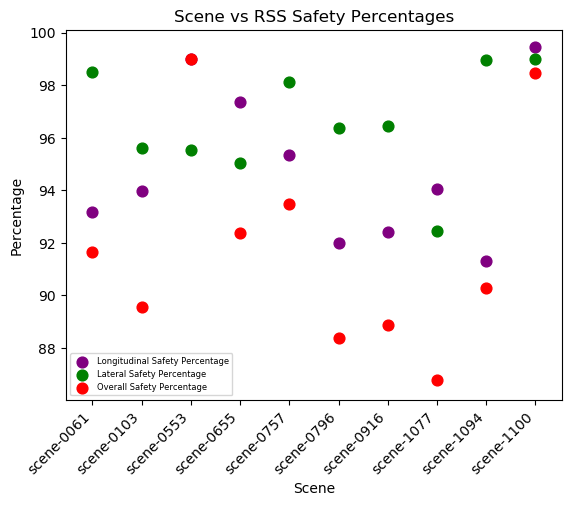

In [40]:
long = plt.scatter(percentages_df['Scene Names'], percentages_df['Longitudinal Safety Percentage'], s=60, c='purple')
lat = plt.scatter(percentages_df['Scene Names'], percentages_df['Lateral Safety Percentage'], s=60, c='green')
overall = plt.scatter(percentages_df['Scene Names'], percentages_df['Overall Safety Percentage'], s=60, c='red')

plt.legend((long, lat, overall),
           ('Longitudinal Safety Percentage', 'Lateral Safety Percentage', 'Overall Safety Percentage'),
           scatterpoints=1,
           loc='best',
           fontsize=6)

plt.xticks(rotation=45, ha='right')
plt.title("Scene vs RSS Safety Percentages")
plt.xlabel("Scene")
plt.ylabel("Percentage")

plt.show()

Overall, we can see that longtudinal safety is lower than lateral safety as a general trend. However, most of the scenes have a generally high safety score in terms of RSS safety. 